# Лабораторная работа №4


# Линейные модели, SVM и деревья решений.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных


In [2]:
data = pd.read_csv('BIKE DETAILS.csv', sep=",")

In [3]:
data.shape

(1061, 7)

In [4]:
# типы колонок
data.dtypes

name                  object
selling_price          int64
year                   int64
seller_type           object
owner                 object
km_driven              int64
ex_showroom_price    float64
dtype: object

In [5]:
data.replace('NA', np.nan, inplace=True)

In [6]:
data.head(5)

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN


In [7]:
# кол-во пропущенные значений (тк нулевые значения в данном датасете - конкретное значения)
nan_count = (data.isna().sum())
print(nan_count)

name                   0
selling_price          0
year                   0
seller_type            0
owner                  0
km_driven              0
ex_showroom_price    435
dtype: int64


Обработка пропусков в числовых данных

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

imp = SimpleImputer(strategy='median')

data['ex_showroom_price'] = imp.fit_transform(data[['ex_showroom_price']])

In [9]:
nan_count = (data.isna().sum())
print(nan_count)

name                 0
selling_price        0
year                 0
seller_type          0
owner                0
km_driven            0
ex_showroom_price    0
dtype: int64


In [10]:
data.head(5)

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,72752.5
1,Honda Dio,45000,2017,Individual,1st owner,5650,72752.5
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,72752.5


### Сделаем кодирование категориальных признаков с помощью LabelEncoder

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
label_encoder = LabelEncoder()

data= data.drop('name', axis=1)

data['seller_type'] = label_encoder.fit_transform(data['seller_type'])
data['owner'] = label_encoder.fit_transform(data['owner'])


In [13]:
data.head()

,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,175000,2019,1,0,350,72752.5
1,45000,2017,1,0,5650,72752.5
2,150000,2018,1,0,12000,148114.0
3,65000,2015,1,0,23000,89643.0
4,20000,2011,1,1,21000,72752.5


## С использованием метода train_test_split разделим выборку на обучающую и тестовую.

In [14]:
X = data.drop('selling_price', axis=1)
y = data['selling_price']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=1)

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((848, 5), (848,), (213, 5), (213,))

## Обучение моделей

### Модель линейной регрессии

<Axes: >

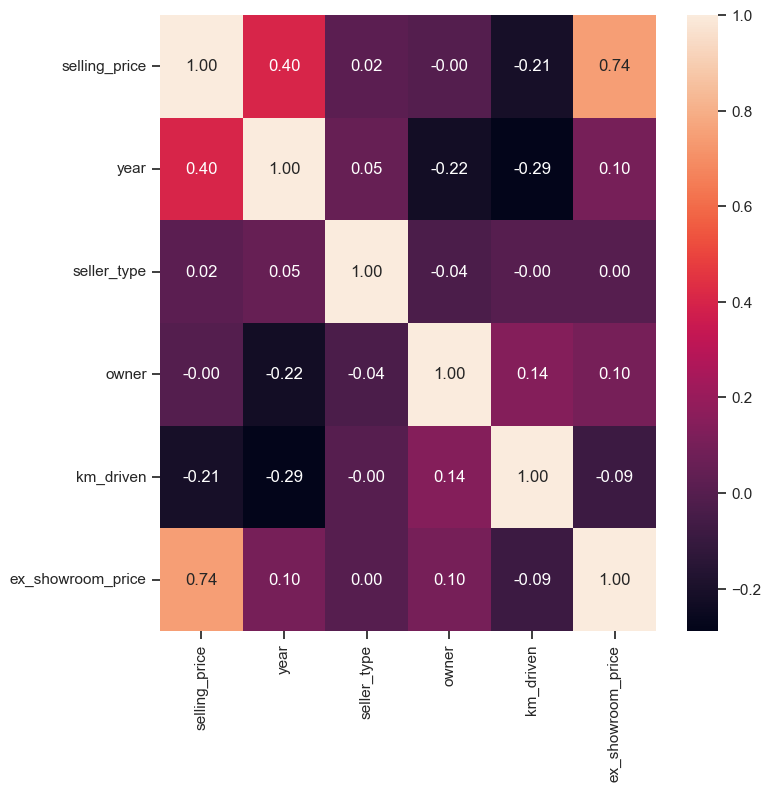

In [17]:
# построим корреляционную матрицу для выявления линейной зависимости
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

<Axes: xlabel='ex_showroom_price', ylabel='selling_price'>

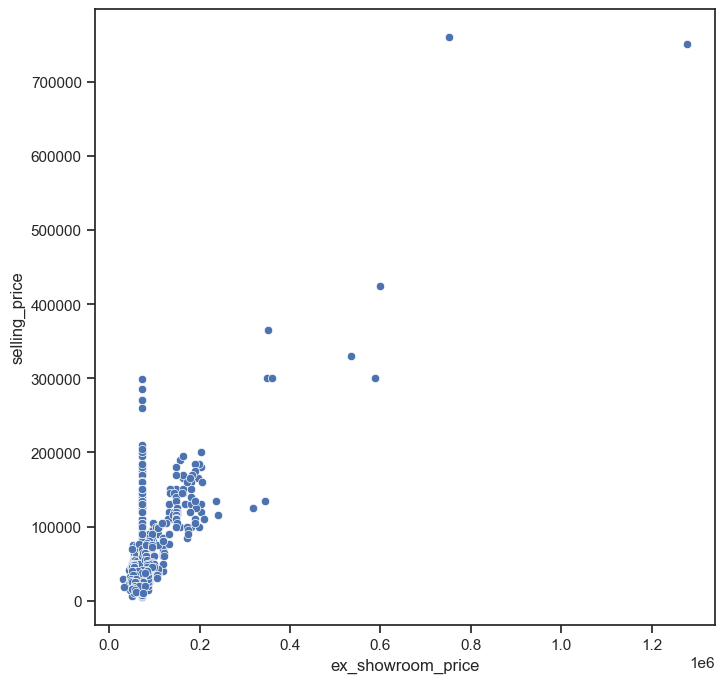

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(ax=ax, x='ex_showroom_price', y='selling_price', data=data)

## Аналитическое восстановление зависимости

In [19]:
from typing import Dict, Tuple

# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-y_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [20]:
x_array = data['ex_showroom_price'].values
y_array = data['selling_price'].values

In [21]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(2551.6455033402526, 0.6985254021750386)

In [22]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [23]:
y_array_regr = y_regr(x_array, b0, b1)

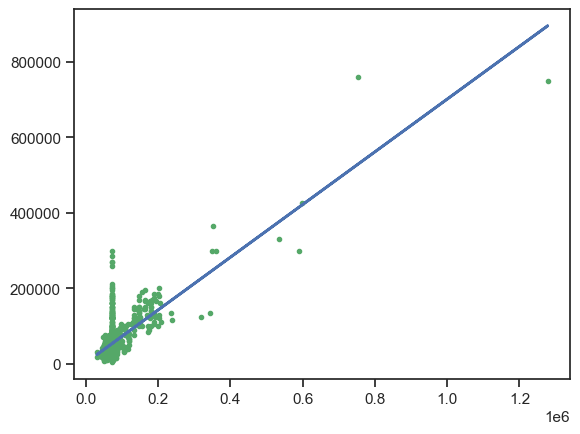

In [24]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

## Восстановление зависимости с использованием численных методов

### Метод наименьших квадратов

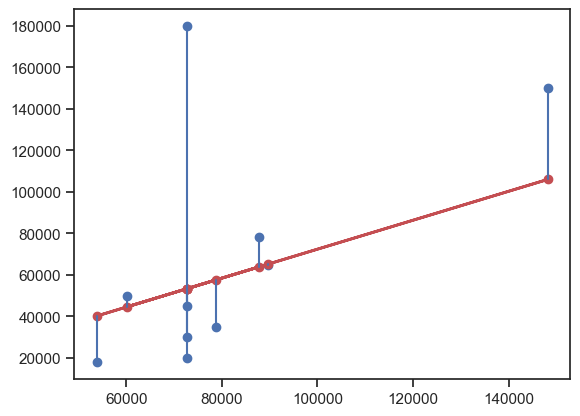

In [25]:
# Синими отрезками показаны ошибки между 
# истинными и предсказанными значениями
K_mnk=10

plt.plot(x_array[1:K_mnk+1], y_array[1:K_mnk+1], 'bo')
plt.plot(x_array[1:K_mnk+1], y_array_regr[1:K_mnk+1], '-ro', linewidth=2.0)

for i in range(len(x_array[1:K_mnk+1])):
    x1 = x_array[1:K_mnk+1][i]
    y1 = y_array[1:K_mnk+1][i]
    y2 = y_array_regr[1:K_mnk+1][i]
    plt.plot([x1,x1],[y1,y2],'b-')

plt.show()

### Решение задачи оптимизации - градиентный спуск или метод наискорейшего спуска

In [26]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        # используется векторизованное умножение и сложение для вектора и константы
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        # np.multiply - поэлементное умножение векторов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred
    

In [27]:
from sklearn.metrics import mean_squared_error

def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = 2551.6455033402526 - (теоретический), 119.27630348727615 - (градиентный спуск)
b1 = 0.6985254021750386 - (теоретический), 14768362.666088594 - (градиентный спуск)
MSE = 2.2404935114877043e+24


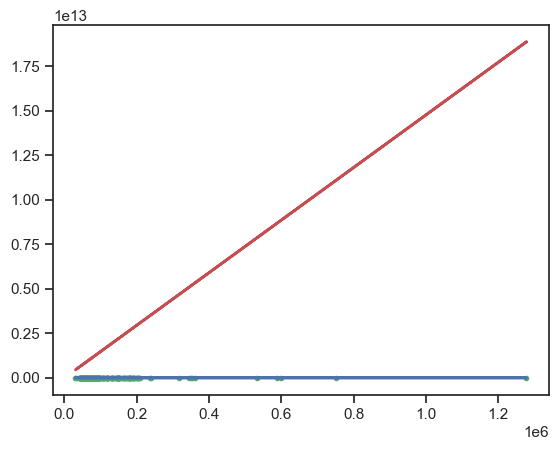

In [28]:
# Примеры использования градиентного спуска
show_gradient_descent(1, 0, 0)

Добьемся сходимости алгоритма путем задания других коэффициентов:

b0 = 2551.6455033402526 - (теоретический), -1.5815057278912319e+143 - (градиентный спуск)
b1 = 0.6985254021750386 - (теоретический), -1.9879183560674342e+148 - (градиентный спуск)
MSE = inf


C:\Users\dasha\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
C:\Users\dasha\anaconda3\Lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


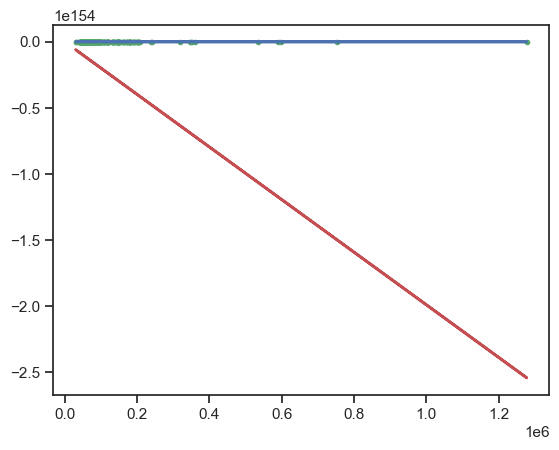

In [29]:
show_gradient_descent(20, 100, -110)

Подбор коэффициентов через LinearRegression

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
regr1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))
(b1, regr1.coef_), (b0, regr1.intercept_)

((0.6985254021750386, array([[0.6985254]])),
 (2551.6455033402526, array([2551.64550334])))

In [32]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

## Стохастический градиентный спуск

In [33]:
from sklearn.linear_model import SGDRegressor

# Для небольшой выборки качество обучения сильно уступает нестохастическому градиентному спуску.
print('Размер выборки - {}'.format(x_array.shape[0]))
reg2 = SGDRegressor().fit(x_array.reshape(-1, 1), y_array)
(b1, reg2.coef_), (b0, reg2.intercept_)

Размер выборки - 1061


((0.6985254021750386, array([7.2692886e+12])),
 (2551.6455033402526, array([1.23511563e+11])))

In [34]:
model2 = SGDRegressor()
model2.fit(X_train, y_train)

SGDRegressor()

### Использование регуляризации в линейных моделях

In [35]:
from sklearn.linear_model import Lasso

In [36]:
reg3 = Lasso().fit(x_array.reshape(-1, 1), y_array)
(b1, reg3.coef_), (b0, reg3.intercept_)

((0.6985254021750386, array([0.6985254])),
 (2551.6455033402526, 2551.6455260812218))

In [37]:
model3 = Lasso()
model3.fit(X_train, y_train)

Lasso()

## SVM модель

In [38]:
# Будем использовать класс SVR для решения задачи регрессии методом опорных векторов
from sklearn.svm import SVR

In [39]:
# regr4 = SVR(kernel='linear', C=1.0)
# model4 = regr4.fit(X_train, y_train)

## Дерево решений

In [40]:
from sklearn.tree import DecisionTreeRegressor

In [41]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

In [42]:
regr5 = DecisionTreeRegressor(max_depth=3)
model5 = regr5.fit(X_train, y_train)

In [43]:
stat_tree(model5)

Всего узлов: 15
Листовых узлов: 8
Глубина дерева: 3
Минимальная глубина листьев дерева: 3
Средняя глубина листьев дерева: 3.0


In [44]:
regr6 = DecisionTreeRegressor(max_depth=5)
model6 = regr6.fit(X_train, y_train)
stat_tree(model6)

Всего узлов: 41
Листовых узлов: 21
Глубина дерева: 5
Минимальная глубина листьев дерева: 3
Средняя глубина листьев дерева: 4.619047619047619


## График важности признаков в дереве решений

In [45]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

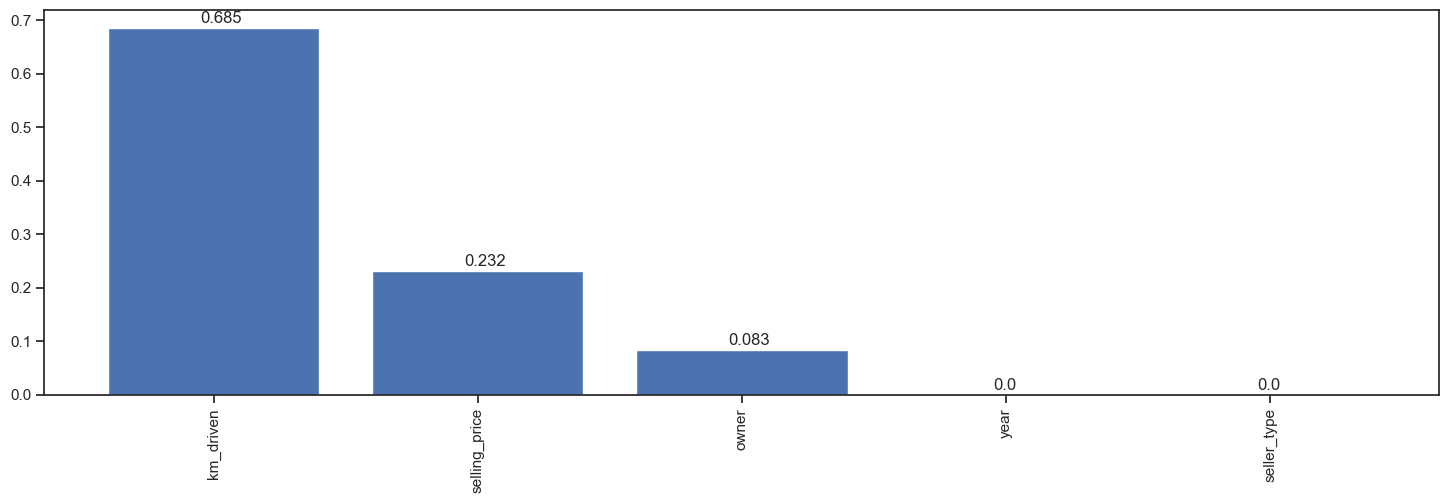

In [46]:

sal_tree_cl_fl_1, sal_tree_cl_fd_1 = draw_feature_importances(model5, data)

## Визуализация деревьев решений и его правила

In [47]:
! pip install pydotplus


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
from io import StringIO
from IPython.display import Image
import graphviz
import pydotplus
from sklearn.tree import export_graphviz

## Визуализация деревьев

In [50]:
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

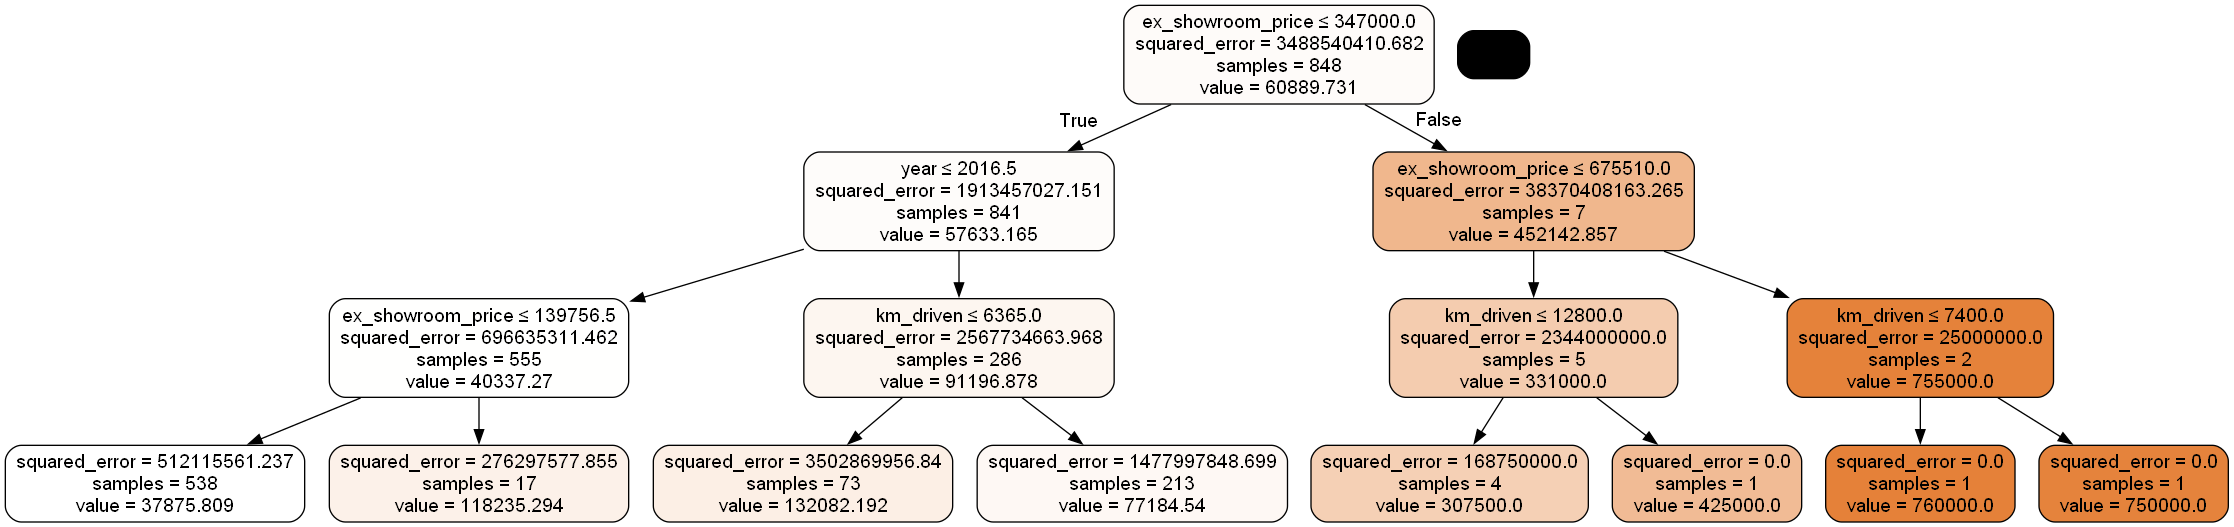

In [51]:

Image(get_png_tree(model5, X.columns), height='70%')

## Вывод правил дерева

In [62]:
from IPython.core.display import HTML
from sklearn.tree import export_text
tree_rules = export_text(model5, feature_names=X.columns)
HTML('<pre>' + tree_rules + '</pre>')

## Оценка качества моделей с помощью двух метрик. Сравнение качества.

In [52]:
# Оценивать качество регрессии будем при помощи двух метрик -
# средней абсолютной ошибки (Mean Absolute Error) и медианной абсолютной ошибки (Median Absolute Error):
from sklearn.metrics import mean_absolute_error, median_absolute_error

In [53]:
err1 = []
err2 = []

In [54]:
def rate_model(model):
    print("Средняя абсолютная ошибка:",
          mean_absolute_error(y_test, model.predict(X_test)))
    err1.append(mean_absolute_error(y_test, model.predict(X_test)))
    print("Медианная абсолютная ошибка:",
          median_absolute_error(y_test, model.predict(X_test)))
    err2.append(median_absolute_error(y_test, model.predict(X_test)))

In [55]:
rate_model(model1)

Средняя абсолютная ошибка: 19269.520029182295
Медианная абсолютная ошибка: 13801.262468459085


In [56]:
rate_model(model2)

Средняя абсолютная ошибка: 5.543056091533853e+18
Медианная абсолютная ошибка: 4.0420364010290903e+18


In [57]:
rate_model(model3)

Средняя абсолютная ошибка: 19269.84840068145
Медианная абсолютная ошибка: 13799.346067270264


In [58]:
rate_model(model5)

Средняя абсолютная ошибка: 23358.114799647316
Медианная абсолютная ошибка: 17124.191449814127


In [59]:
rate_model(model6)

Средняя абсолютная ошибка: 17836.05122550614
Медианная абсолютная ошибка: 10767.955801104974
